# Dependencies

- Discussion [thread](https://www.kaggle.com/c/cassava-leaf-disease-classification/discussion/198744)
- Reference: [How To Create TFRecords](https://www.kaggle.com/cdeotte/how-to-create-tfrecords)

In [1]:
import re, math, os, cv2, random, warnings
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt

def seed_everything(seed=0):
    random.seed(seed)
    np.random.seed(seed)
    tf.random.set_seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    os.environ['TF_DETERMINISTIC_OPS'] = '1'

seed = 0
seed_everything(seed)
warnings.filterwarnings('ignore')

### Find & remove duplicates

In [2]:
import glob, torch, imagehash
from tqdm.auto import tqdm
from PIL import Image



os.mkdir('/kaggle/working/train/')
!cp -r /kaggle/input/cassava-leaf-disease-classification/train_images/* train # move data to "train" folder



IMAGES_DIR = '/kaggle/working/train/'

funcs = [
        imagehash.average_hash,
        imagehash.phash,
        imagehash.dhash,
        imagehash.whash,
    ]
image_ids = []
hashes = []

for path in tqdm(glob.glob(IMAGES_DIR + '*.jpg')):
    image = Image.open(path)
    image_id = os.path.basename(path)
    image_ids.append(image_id)
    hashes.append(np.array([f(image).hash for f in funcs]).reshape(256))

hashes_all = np.array(hashes)
hashes_all = torch.Tensor(hashes_all.astype(int))



sims = np.array([(hashes_all[i] == hashes_all).sum(dim=1).numpy()/256 for i in range(hashes_all.shape[0])])

indices1 = np.where(sims > 0.9)
indices2 = np.where(indices1[0] != indices1[1])
image_ids1 = [image_ids[i] for i in indices1[0][indices2]]
image_ids2 = [image_ids[i] for i in indices1[1][indices2]]
dups = {tuple(sorted([image_id1,image_id2])):True for image_id1, image_id2 in zip(image_ids1, image_ids2)}
duplicate_image_ids = sorted(list(dups))
print('found %d duplicates' % len(duplicate_image_ids))



# Remove duplicates from external data
imgs_to_remove = [x[1] for x in duplicate_image_ids]
remove_pd = []
for image in imgs_to_remove:
    remove_pd.append(image)



!rm -r /kaggle/working/train/ # delete image files


found 2 duplicates


# Auxiliar functions

In [3]:
def decode_image(image_data):
    image = tf.image.decode_jpeg(image_data, channels=3)
    image = tf.cast(image, tf.float32) / 255.0
                      
    image = tf.image.resize(image, [HEIGHT, WIDTH])
    image = tf.reshape(image, [HEIGHT, WIDTH, 3])
    return image

def read_tfrecord(example):
    TFREC_FORMAT = {
        'image': tf.io.FixedLenFeature([], tf.string), 
        'target': tf.io.FixedLenFeature([], tf.int64), 
        'image_name': tf.io.FixedLenFeature([], tf.string), 
    }
    example = tf.io.parse_single_example(example, TFREC_FORMAT)
    image = decode_image(example['image'])
    target = example['target']
    name = example['image_name']
    return image, target, name

def load_dataset(filenames, HEIGHT, WIDTH, CHANNELS=3):
    dataset = tf.data.TFRecordDataset(filenames)
    dataset = dataset.map(read_tfrecord, num_parallel_calls=AUTO)
    return dataset

def display_samples(ds, row, col):
    ds_iter = iter(ds)
    plt.figure(figsize=(15, int(15*row/col)))
    for j in range(row*col):
        image, label, name = next(ds_iter)
        plt.subplot(row,col,j+1)
        plt.axis('off')
        plt.imshow(image[0])
        plt.title(f"{label[0]}: {name[0].numpy().decode('utf-8')}", fontsize=12)
    plt.show()

def count_data_items(filenames):
    n = [int(re.compile(r"-([0-9]*)\.").search(filename).group(1)) for filename in filenames]
    return np.sum(n)


# Create TF Records
def _bytes_feature(value):
  """Returns a bytes_list from a string / byte."""
  if isinstance(value, type(tf.constant(0))):
    value = value.numpy() # BytesList won't unpack a string from an EagerTensor.
  return tf.train.Feature(bytes_list=tf.train.BytesList(value=[value]))

def _int64_feature(value):
  """Returns an int64_list from a bool / enum / int / uint."""
  return tf.train.Feature(int64_list=tf.train.Int64List(value=[value]))

def serialize_example(image, target, image_name):
  feature = {
      'image': _bytes_feature(image),
      'target': _int64_feature(target),
      'image_name': _bytes_feature(image_name),
  }
  example_proto = tf.train.Example(features=tf.train.Features(feature=feature))
  return example_proto.SerializeToString()

# Parameters

In [4]:
database_base_path = '/kaggle/input/cassava-leaf-disease-classification/'
PATH = f'{database_base_path}train_images/'
IMGS = os.listdir(PATH)
FILE_SIZE = 128 # 128 images per TFRecord file
HEIGHT, WIDTH = (512, 512)
IMG_QUALITY = 100

CLASSES = ['Cassava Bacterial Blight', 
           'Cassava Brown Streak Disease', 
           'Cassava Green Mottle', 
           'Cassava Mosaic Disease', 
           'Healthy']

CLASSES_SHORT = ['CBB', 
                 'CBSD', 
                 'CGM', 
                 'CMD', 
                 'Healthy']

print(f'Image samples: {len(IMGS)}')

Image samples: 21397


# Load data

In [5]:
# train = pd.read_csv(database_base_path + 'train.csv')
train = pd.read_csv('/kaggle/input/cassava-leaf-disease-50-tfrecords-center-512x512/train.csv')
N_FILES = train['file'].max() + 1

# # Remove duplicates from train data
# train = train[~train['image_id'].isin(remove_pd)]
# train.reset_index(inplace=True)
print('Train samples: %d' % len(train))

display(train.head())

Train samples: 21395


index        image_id  label  file
0      0  1000015157.jpg      0     9
1      1  1000201771.jpg      3     5
2      2   100042118.jpg      1    11
3      3  1000723321.jpg      1    17
4      4  1000812911.jpg      3    40

# Generate TF records (splited by classes)

In [6]:
for label in train['label'].unique():
    print(f'\nWriting TFRecord for class "{CLASSES[label]}"...')
    class_ds = train[train['label'] == label].reset_index(drop=True)
    for tfrec_num in range(N_FILES):
        print(f'Writing TFRecord {tfrec_num+1} of {N_FILES}...')
        samples = class_ds[class_ds['file'] == tfrec_num]
        n_samples = len(samples)
        print(f'{n_samples} samples')
        with tf.io.TFRecordWriter(f'{CLASSES_SHORT[label]}{tfrec_num}-{n_samples}.tfrec') as writer:
            for row in samples.itertuples():
                label = row.label
                image_name = row.image_id
                img_path = f'{PATH}{image_name}'
                # Load image
                img = cv2.imread(img_path)
                # Center crop image
                img_height, img_width, _ = img.shape
                min_axis = min(img_height, img_width)
                adj_height, adj_width = ((img_height - min_axis)//2), ((img_width - min_axis)//2)
                img = img[0+adj_height:min_axis+adj_height, 0+adj_width:min_axis+adj_width]
                # Resize image
                img = cv2.resize(img, (HEIGHT, WIDTH))
                img = cv2.imencode('.jpg', img, (cv2.IMWRITE_JPEG_QUALITY, IMG_QUALITY))[1].tostring()

                example = serialize_example(img, label, str.encode(image_name))
                writer.write(example)


Writing TFRecord for class "Cassava Bacterial Blight"...
Writing TFRecord 1 of 50...
22 samples
Writing TFRecord 2 of 50...
22 samples
Writing TFRecord 3 of 50...
22 samples
Writing TFRecord 4 of 50...
22 samples
Writing TFRecord 5 of 50...
22 samples
Writing TFRecord 6 of 50...
22 samples
Writing TFRecord 7 of 50...
22 samples
Writing TFRecord 8 of 50...
22 samples
Writing TFRecord 9 of 50...
22 samples
Writing TFRecord 10 of 50...
22 samples
Writing TFRecord 11 of 50...
22 samples
Writing TFRecord 12 of 50...
22 samples
Writing TFRecord 13 of 50...
22 samples
Writing TFRecord 14 of 50...
22 samples
Writing TFRecord 15 of 50...
22 samples
Writing TFRecord 16 of 50...
22 samples
Writing TFRecord 17 of 50...
22 samples
Writing TFRecord 18 of 50...
22 samples
Writing TFRecord 19 of 50...
22 samples
Writing TFRecord 20 of 50...
22 samples
Writing TFRecord 21 of 50...
22 samples
Writing TFRecord 22 of 50...
22 samples
Writing TFRecord 23 of 50...
22 samples
Writing TFRecord 24 of 50...
22

# Visualize created TF records

## Class map

```
0: Cassava Bacterial Blight (CBB)
1: Cassava Brown Streak Disease (CBSD)
2: Cassava Green Mottle (CGM)
3: Cassava Mosaic Disease (CMD)
4: Healthy
```

## 0: Cassava Bacterial Blight (CBB)

TFRecords files: ['./CBB40-21.tfrec', './CBB28-22.tfrec', './CBB8-22.tfrec', './CBB6-22.tfrec', './CBB27-22.tfrec', './CBB36-21.tfrec', './CBB42-21.tfrec', './CBB12-22.tfrec', './CBB2-22.tfrec', './CBB5-22.tfrec', './CBB14-22.tfrec', './CBB23-22.tfrec', './CBB38-21.tfrec', './CBB4-22.tfrec', './CBB41-21.tfrec', './CBB15-22.tfrec', './CBB43-21.tfrec', './CBB11-22.tfrec', './CBB7-22.tfrec', './CBB44-21.tfrec', './CBB32-22.tfrec', './CBB17-22.tfrec', './CBB0-22.tfrec', './CBB26-22.tfrec', './CBB21-22.tfrec', './CBB16-22.tfrec', './CBB1-22.tfrec', './CBB9-22.tfrec', './CBB31-22.tfrec', './CBB45-21.tfrec', './CBB25-22.tfrec', './CBB47-21.tfrec', './CBB33-22.tfrec', './CBB10-22.tfrec', './CBB49-21.tfrec', './CBB24-22.tfrec', './CBB35-22.tfrec', './CBB37-21.tfrec', './CBB13-22.tfrec', './CBB48-21.tfrec', './CBB3-22.tfrec', './CBB18-22.tfrec', './CBB20-22.tfrec', './CBB34-22.tfrec', './CBB46-21.tfrec', './CBB22-22.tfrec', './CBB29-22.tfrec', './CBB19-22.tfrec', './CBB30-22.tfrec', './CBB39-21.

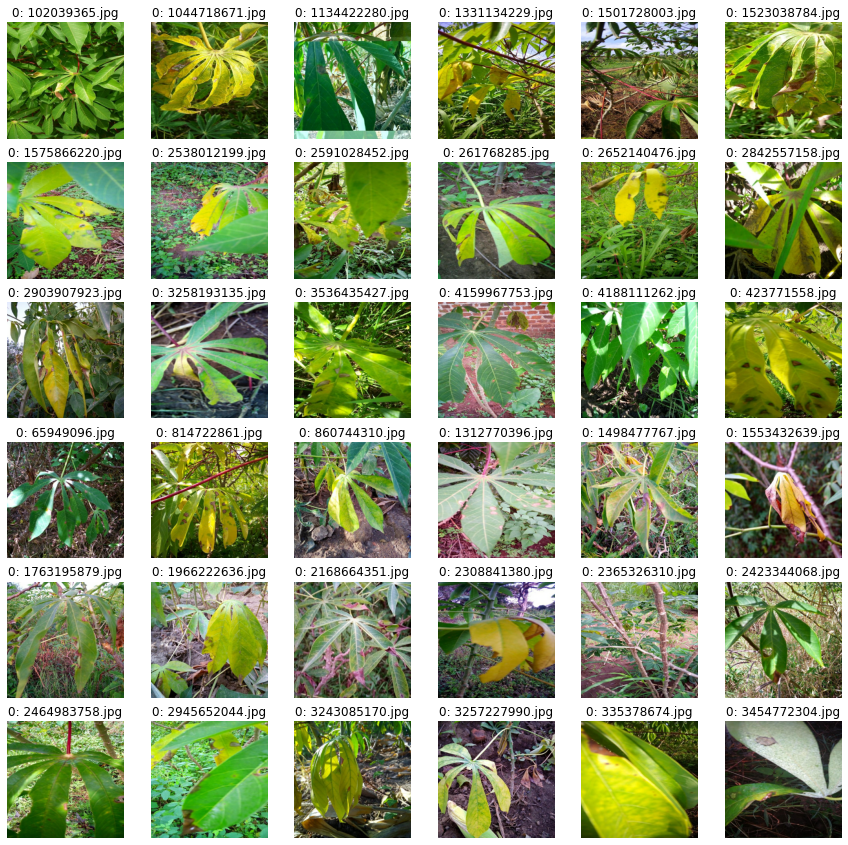

In [7]:
AUTO = tf.data.experimental.AUTOTUNE
FILENAMES = tf.io.gfile.glob('CBB*.tfrec')
print(f'TFRecords files: {FILENAMES}')
print(f'Created image samples: {count_data_items(FILENAMES)}')

display_samples(load_dataset(FILENAMES, HEIGHT, WIDTH).batch(1), 6, 6)

## 1: Cassava Brown Streak Disease (CBSD)

TFRecords files: ['./CBSD28-44.tfrec', './CBSD7-44.tfrec', './CBSD12-44.tfrec', './CBSD10-44.tfrec', './CBSD29-44.tfrec', './CBSD13-44.tfrec', './CBSD41-43.tfrec', './CBSD30-44.tfrec', './CBSD0-44.tfrec', './CBSD47-44.tfrec', './CBSD49-44.tfrec', './CBSD23-44.tfrec', './CBSD43-43.tfrec', './CBSD31-44.tfrec', './CBSD27-44.tfrec', './CBSD37-43.tfrec', './CBSD2-44.tfrec', './CBSD16-44.tfrec', './CBSD48-44.tfrec', './CBSD19-44.tfrec', './CBSD17-44.tfrec', './CBSD36-43.tfrec', './CBSD45-44.tfrec', './CBSD42-43.tfrec', './CBSD20-44.tfrec', './CBSD14-44.tfrec', './CBSD4-44.tfrec', './CBSD39-43.tfrec', './CBSD5-44.tfrec', './CBSD3-44.tfrec', './CBSD21-44.tfrec', './CBSD33-43.tfrec', './CBSD1-44.tfrec', './CBSD44-44.tfrec', './CBSD46-44.tfrec', './CBSD25-44.tfrec', './CBSD15-44.tfrec', './CBSD35-43.tfrec', './CBSD8-44.tfrec', './CBSD32-44.tfrec', './CBSD22-44.tfrec', './CBSD26-44.tfrec', './CBSD18-44.tfrec', './CBSD34-43.tfrec', './CBSD6-44.tfrec', './CBSD40-43.tfrec', './CBSD11-44.tfrec', './C

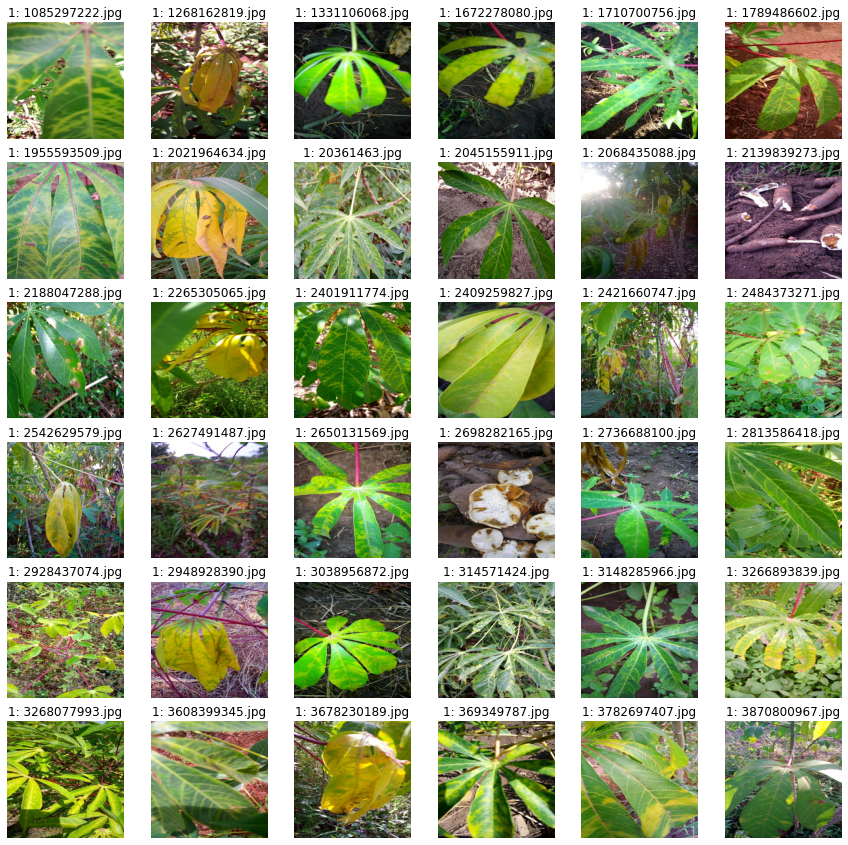

In [8]:
AUTO = tf.data.experimental.AUTOTUNE
FILENAMES = tf.io.gfile.glob('CBSD*.tfrec')
print(f'TFRecords files: {FILENAMES}')
print(f'Created image samples: {count_data_items(FILENAMES)}')

display_samples(load_dataset(FILENAMES, HEIGHT, WIDTH).batch(1), 6, 6)

## 2: Cassava Green Mottle (CGM)

TFRecords files: ['./CGM24-47.tfrec', './CGM28-47.tfrec', './CGM33-48.tfrec', './CGM44-48.tfrec', './CGM34-48.tfrec', './CGM4-48.tfrec', './CGM38-48.tfrec', './CGM20-47.tfrec', './CGM8-48.tfrec', './CGM43-48.tfrec', './CGM40-48.tfrec', './CGM7-48.tfrec', './CGM9-48.tfrec', './CGM17-48.tfrec', './CGM41-48.tfrec', './CGM21-47.tfrec', './CGM49-48.tfrec', './CGM14-48.tfrec', './CGM12-48.tfrec', './CGM35-48.tfrec', './CGM47-48.tfrec', './CGM13-48.tfrec', './CGM19-47.tfrec', './CGM3-48.tfrec', './CGM45-48.tfrec', './CGM18-48.tfrec', './CGM5-48.tfrec', './CGM26-47.tfrec', './CGM30-47.tfrec', './CGM6-48.tfrec', './CGM11-48.tfrec', './CGM22-47.tfrec', './CGM46-48.tfrec', './CGM39-48.tfrec', './CGM10-48.tfrec', './CGM36-48.tfrec', './CGM23-47.tfrec', './CGM0-48.tfrec', './CGM29-47.tfrec', './CGM37-48.tfrec', './CGM2-48.tfrec', './CGM25-47.tfrec', './CGM15-48.tfrec', './CGM32-47.tfrec', './CGM16-48.tfrec', './CGM1-48.tfrec', './CGM48-48.tfrec', './CGM31-47.tfrec', './CGM42-48.tfrec', './CGM27-47.

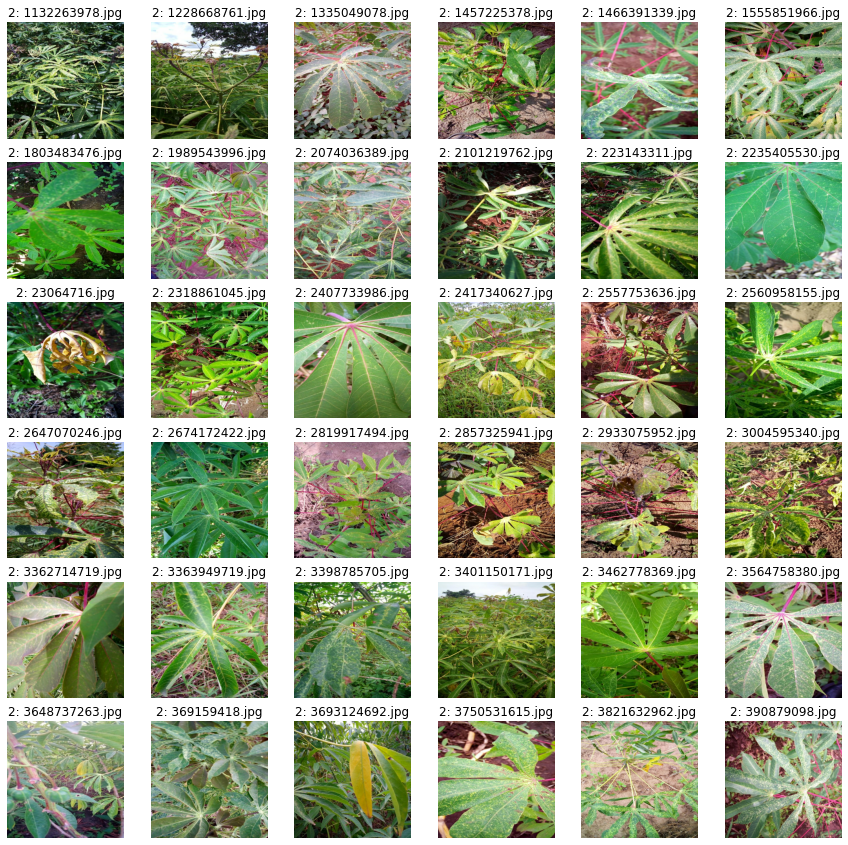

In [9]:
AUTO = tf.data.experimental.AUTOTUNE
FILENAMES = tf.io.gfile.glob('CGM*.tfrec')
print(f'TFRecords files: {FILENAMES}')
print(f'Created image samples: {count_data_items(FILENAMES)}')

display_samples(load_dataset(FILENAMES, HEIGHT, WIDTH).batch(1), 6, 6)

## 3: Cassava Mosaic Disease (CMD)

TFRecords files: ['./CMD16-263.tfrec', './CMD12-263.tfrec', './CMD29-263.tfrec', './CMD36-264.tfrec', './CMD18-263.tfrec', './CMD2-263.tfrec', './CMD24-263.tfrec', './CMD20-263.tfrec', './CMD23-263.tfrec', './CMD31-263.tfrec', './CMD32-263.tfrec', './CMD49-263.tfrec', './CMD15-263.tfrec', './CMD47-263.tfrec', './CMD10-263.tfrec', './CMD21-263.tfrec', './CMD40-264.tfrec', './CMD13-263.tfrec', './CMD34-263.tfrec', './CMD8-263.tfrec', './CMD42-264.tfrec', './CMD25-263.tfrec', './CMD28-263.tfrec', './CMD43-264.tfrec', './CMD26-263.tfrec', './CMD5-263.tfrec', './CMD4-263.tfrec', './CMD3-263.tfrec', './CMD1-263.tfrec', './CMD17-263.tfrec', './CMD35-263.tfrec', './CMD38-264.tfrec', './CMD27-263.tfrec', './CMD11-263.tfrec', './CMD22-263.tfrec', './CMD39-264.tfrec', './CMD14-263.tfrec', './CMD48-263.tfrec', './CMD6-263.tfrec', './CMD30-263.tfrec', './CMD19-263.tfrec', './CMD41-264.tfrec', './CMD45-263.tfrec', './CMD0-263.tfrec', './CMD46-263.tfrec', './CMD33-263.tfrec', './CMD7-263.tfrec', './C

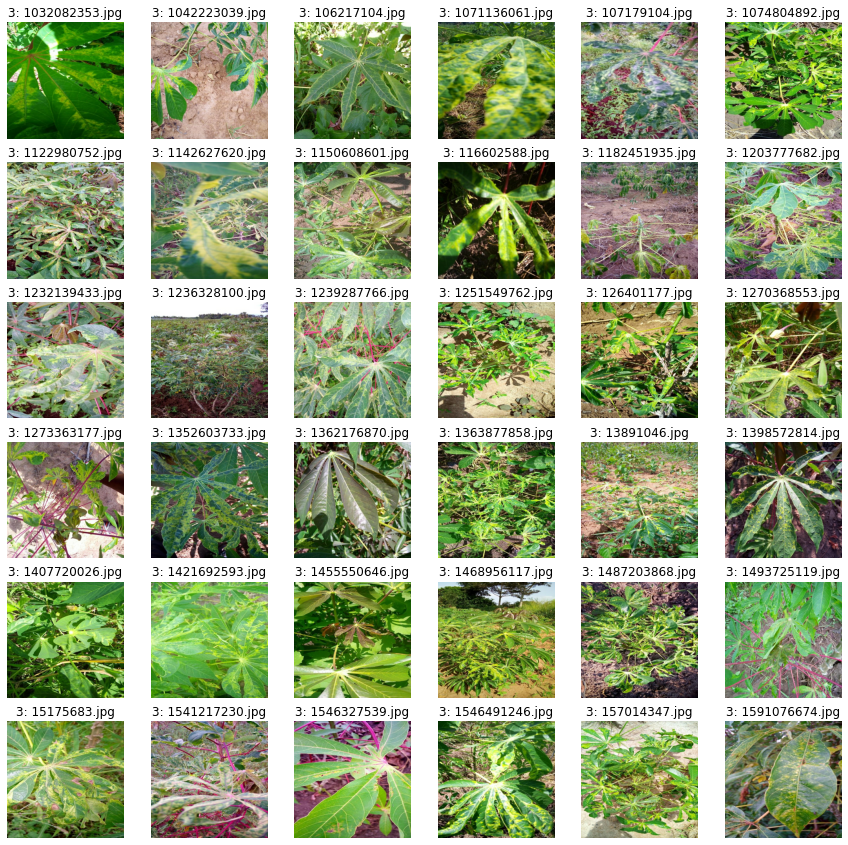

In [10]:
AUTO = tf.data.experimental.AUTOTUNE
FILENAMES = tf.io.gfile.glob('CMD*.tfrec')
print(f'TFRecords files: {FILENAMES}')
print(f'Created image samples: {count_data_items(FILENAMES)}')

display_samples(load_dataset(FILENAMES, HEIGHT, WIDTH).batch(1), 6, 6)

## 4: Healthy

TFRecords files: ['./Healthy18-51.tfrec', './Healthy45-51.tfrec', './Healthy6-51.tfrec', './Healthy32-52.tfrec', './Healthy4-51.tfrec', './Healthy36-52.tfrec', './Healthy19-52.tfrec', './Healthy42-52.tfrec', './Healthy49-51.tfrec', './Healthy13-51.tfrec', './Healthy44-52.tfrec', './Healthy15-51.tfrec', './Healthy17-51.tfrec', './Healthy16-51.tfrec', './Healthy7-51.tfrec', './Healthy30-52.tfrec', './Healthy29-52.tfrec', './Healthy48-51.tfrec', './Healthy25-52.tfrec', './Healthy27-52.tfrec', './Healthy8-51.tfrec', './Healthy43-52.tfrec', './Healthy31-52.tfrec', './Healthy5-51.tfrec', './Healthy38-52.tfrec', './Healthy23-52.tfrec', './Healthy40-52.tfrec', './Healthy1-51.tfrec', './Healthy21-52.tfrec', './Healthy39-52.tfrec', './Healthy20-52.tfrec', './Healthy9-51.tfrec', './Healthy11-51.tfrec', './Healthy41-52.tfrec', './Healthy46-51.tfrec', './Healthy2-51.tfrec', './Healthy14-51.tfrec', './Healthy12-51.tfrec', './Healthy47-51.tfrec', './Healthy0-51.tfrec', './Healthy26-52.tfrec', './Heal

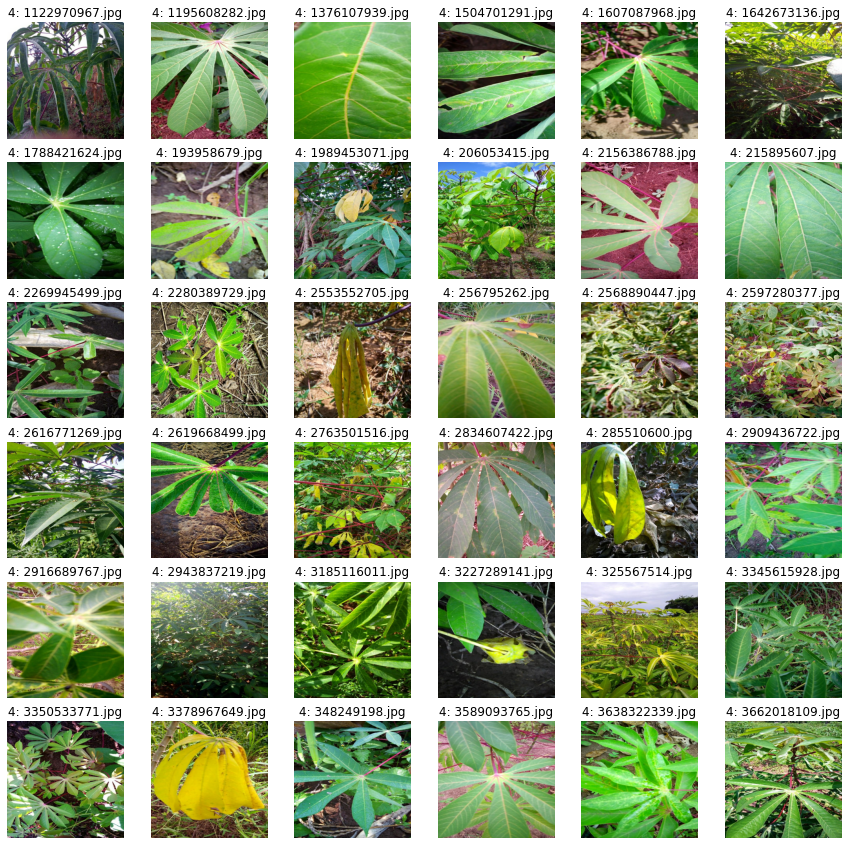

In [11]:
AUTO = tf.data.experimental.AUTOTUNE
FILENAMES = tf.io.gfile.glob('Healthy*.tfrec')
print(f'TFRecords files: {FILENAMES}')
print(f'Created image samples: {count_data_items(FILENAMES)}')

display_samples(load_dataset(FILENAMES, HEIGHT, WIDTH).batch(1), 6, 6)